In [2]:
import json
import pandas as pd
import numpy as np

In [3]:
time = []
flow = []
tot_1 = []
tot_2 = []
analog_2 = []
with open('B1586024706369.json') as file:
    data = json.load(file)
    for i in np.arange(0,len(data)-1): 
        time.append(data[i]['timeStamp'])
        flow.append(data[i]['idflowmeter'])
        tot_1.append(data[i]['tot1'])
        tot_2.append(data[i]['tot2'])
        analog_2.append(data[i]['analog2'])

In [5]:
flows_data = pd.DataFrame(
    {'Times': time,
     'Total_1' : tot_1,
     'Total_2'  : tot_2,
     'Analog_2' : analog_2
    })

In [19]:
#df = flows_data.set_index('Times').resample('1H').pad()
#print (df)
flows_data['Times'] = pd.to_datetime(flows_data['Times'], errors = 'coerce')

C:\Users\joaoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
flows_data = flows_data.set_index('Times')

In [27]:
hour_summary1 = flows_data.Total_1.resample('60T').sum()
hour_summary2 = flows_data.Total_2.resample('60T').sum()

In [28]:
hour_summary1['hour'] = flows_data.Total_1.resample('60T').transform('sum')
hour_summary2['hour'] = flows_data.Total_2.resample('60T').transform('sum')

In [41]:
hour_summary1['hour']

Times
NaT                           NaN
2000-01-01 00:00:00          0.00
2000-01-01 00:00:00          0.00
2000-01-01 00:00:00          0.00
2000-01-01 00:00:00          0.00
                          ...    
2020-04-01 14:04:00    8796848.62
2020-04-01 14:05:00    8796848.62
2020-04-01 14:06:00    8796848.62
2020-04-01 14:07:00    8796848.62
2020-04-01 14:08:00    8796848.62
Name: Total_1, Length: 1395744, dtype: float64

In [42]:
hour_summary2['hour']

Times
NaT                         NaN
2000-01-01 00:00:00        0.00
2000-01-01 00:00:00        0.00
2000-01-01 00:00:00        0.00
2000-01-01 00:00:00        0.00
                         ...   
2020-04-01 14:04:00   -42418.89
2020-04-01 14:05:00   -42418.89
2020-04-01 14:06:00   -42418.89
2020-04-01 14:07:00   -42418.89
2020-04-01 14:08:00   -42418.89
Name: Total_2, Length: 1395744, dtype: float64

In [20]:
import matplotlib.pyplot as plt

In [31]:
flows_data['Total_1'].plot(kind='box')
plt.show()

TypeError: no numeric data to plot

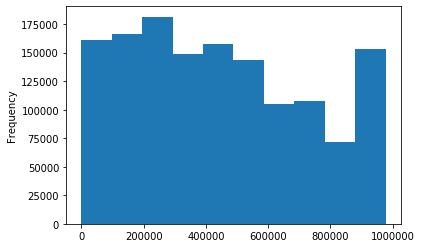

In [71]:
flows_data['Total_1'].plot(kind='hist')
plt.show()

In [84]:
value_t1 = []

# Where NaN
#flows_data['value_t1'] = flows_data['Total_1'].shift(-1)-flows_data['Total_1']


value_t2 = []

#where NaN
#flows_data['value_t2'] = flows_data['Total_2'].shift(-1)-flows_data['Total_2']
I = range(0, len(flows_data['Total_1'])-1)

for i in I:
    value_t1.append(flows_data['Total_1'][i+1]-flows_data['Total_1'][i])
    
I = range(0, len(flows_data['Total_2'])-1)

for i in I:
    value_t2.append(flows_data['Total_2'][i+1]-flows_data['Total_2'][i])

In [85]:
# error
#flows_data[['Times','Total_1']].resample('1T').sum()
#flows_data[['Times','Total_2']].resample('1T').sum()

In [86]:
flows_kmeans = pd.DataFrame({
    'Number of samples' : np.arange(0,len(value_t1)),
    'Value1 at time t' : value_t1,
    'Value2 at time t' : value_t2
})

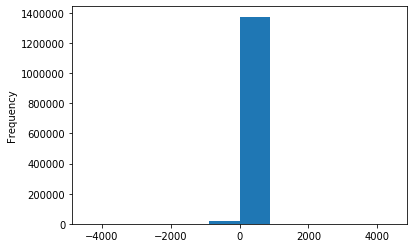

In [88]:
flows_kmeans['Value at time t'].plot(kind='hist')

In [89]:
print('Minimum value ' + str(flows_kmeans['Value1 at time t'].min()))
print('Maximum value ' + str(flows_kmeans['Value1 at time t'].max()))
print('Minimum value ' + str(flows_kmeans['Value2 at time t'].min()))
print('Maximum value ' + str(flows_kmeans['Value2 at time t'].max()))

Minimum value -716574.25
Maximum value 716578.31
Minimum value -4419.24
Maximum value 4419.24


In [93]:
# Convert the flow values to a numpy array
flows_raw1 = flows_kmeans['Value1 at time t'].values
flows_raw2 = flows_kmeans['Value2 at time t'].values

In [94]:
# For compatibility with scipy implementation
flows_raw1 = flows_raw1.reshape(-1, 1)
flows_raw1 = flows_raw1.astype('float64')

flows_raw2 = flows_raw2.reshape(-1, 1)
flows_raw2 = flows_raw2.astype('float64')


In [95]:
from sklearn.cluster import KMeans

In [96]:
distortions1 = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(flows_raw1)
    distortions1.append(kMeanModel.inertia_)
    
distortions2 = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(flows_raw2)
    distortions2.append(kMeanModel.inertia_)

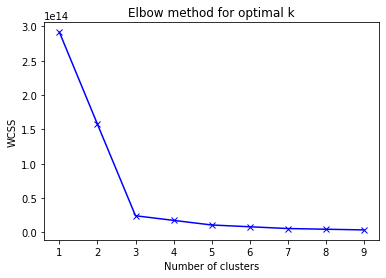

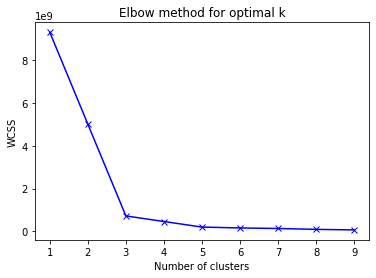

In [97]:
plt.plot(K, distortions1, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(K, distortions2, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [98]:
from scipy.cluster.vq import kmeans, vq

In [99]:
centroids1, avg_distance1 = kmeans(flows_raw1, 3)
centroids2, avg_distance2 = kmeans(flows_raw2, 3)

In [100]:
groups1, cdist1 = vq(flows_raw1, centroids1)
groups2, cdist2 = vq(flows_raw2, centroids2)

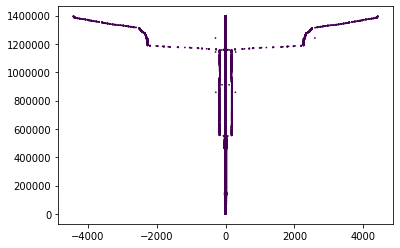

In [103]:
plt.scatter(flows_raw1, np.arange(0,len(flows_raw)), c=groups1, s=0.5)
plt.scatter(flows_raw2, np.arange(0,len(flows_raw)), c=groups2, s=0.5)

In [105]:
from sklearn.ensemble import IsolationForest
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
clf.fit(flows_kmeans)
if_scores = clf.decision_function(flows_kmeans)
if_anomalies=clf.predict(flows_kmeans)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies=flows_kmeans[if_anomalies==1]

(array([  3752.,  12088.,   5098.,   8733.,  33275.,  53789., 118754.,
        224141., 388983., 547130.]),
 array([-0.2072665 , -0.17428135, -0.1412962 , -0.10831105, -0.0753259 ,
        -0.04234075, -0.0093556 ,  0.02362955,  0.0566147 ,  0.08959985,
         0.122585  ]),
 <a list of 10 Patch objects>)

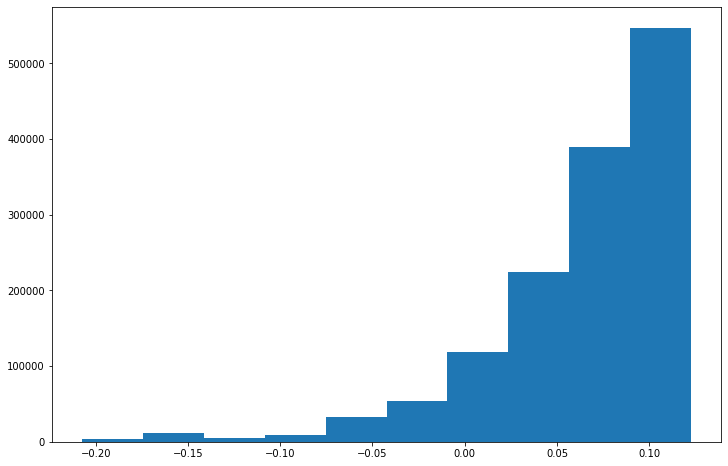

In [106]:
plt.figure(figsize=(12,8))
plt.hist(if_scores)

In [107]:
clf.fit_predict(flows_kmeans)

array([-1, -1, -1, ..., -1, -1, -1])

In [108]:
np.where(clf.fit_predict(flows_kmeans) == 1)

(array([    135,     136,     137, ..., 1395740, 1395741, 1395742],
       dtype=int64),)

In [109]:
np.where(clf.fit_predict(flows_kmeans) == -1)

(array([      0,       1,       2, ..., 1395623, 1395624, 1395630],
       dtype=int64),)

In [110]:
toRemove = np.where(clf.fit_predict(flows_kmeans) == -1)